In [41]:
%reset
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import jax.numpy as jnp


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [42]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)


gpu


In [43]:
def get_cell_coord(x):
    ix = jnp.floor(x)
    return x - ix, ix


def cic(x, y, z, Nx: int, Ny: int, Nz: int, Lx, Ly, Lz):
    Ntot = Nx * Ny * Nz
    x = x * Nx / Lx
    y = y * Ny / Ly
    z = z * Nz / Lz

    qx, ix = get_cell_coord(x)
    qy, iy = get_cell_coord(y)
    qz, iz = get_cell_coord(z)

    ix = ix.astype(int)
    iy = iy.astype(int)
    iz = iz.astype(int)
    rx = 1.0 - qx
    ry = 1.0 - qy
    rz = 1.0 - qz
    jx = (ix + 1) % Nx
    jy = (iy + 1) % Ny
    jz = (iz + 1) % Nz

    rho = jnp.zeros((Ntot,))

    for a in [False, True]:
        for b in [False, True]:
            for c in [False, True]:
                ax = jx if a else ix
                ay = jy if b else iy
                az = jz if c else iz
                ux = qx if a else rx
                uy = qy if b else ry
                uz = qz if c else rz

                idx = az + Nz * ay + Nz * Ny * ax
                rho += jnp.bincount(idx, weights=ux * uy * uz, length=Ntot)

    return rho.reshape((Nx, Ny, Nz)) / (x.shape[0] / Ntot) - 1.0




In [44]:
import numpy as np
import sys,os
import readgadget
import MAS_library as MASL

# This routine computes the density field and save results to file
def compute_df(snapshot, ptypes, grid, fout):
    # if not(os.path.exists(snapshot+'.0')) and not(os.path.exists(snapshot+'.0.hdf5')):
        # return 0
    print(snapshot)
    df = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
                                   do_RSD=False, axis=0, verbose=True)
    df = df/np.mean(df, dtype=np.float64)-1.0
    np.save(fout, df)
    
    
    


In [45]:
# %pip install Pylians


In [46]:
# %pip install Pylians
root         = '/pscratch/sd/s/spandey/quijote/Snapshot_fid'
root_out     = '/pscratch/sd/s/spandey/quijote/Snapshot_fid/Snapshot_fid_density'
ptypes       = [1]
snapnum      = 0
grid         = 512
# numbers = np.arange(0,17)
# for i in numbers:
i = 0
print(i)
# for snapnum in [0,1,2,3,4]:
snapnum = 4
print(snapnum)
# find the redshift
z = {4:0, 3:0.5, 2:1, 1:2, 0:3}[snapnum]

# create output folder if it does not exists
folder_out = '%s/%d'%(root_out,i)
if not(os.path.exists(folder_out)):
    os.system('mkdir %s'%folder_out)

# find name of output file
fout = '%s/df_m_%d_z=%s.npy'%(folder_out,grid,z)
# if os.path.exists(fout):  continue

# compute the density field and save it to file
snapshot = '%s/%d/snapdir_%03d/snap_%03d'%(root,i,snapnum,snapnum)
df = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
                               do_RSD=False, axis=0, verbose=True)
df_pylians = df/np.mean(df, dtype=np.float64)-1.0

# compute_df(snapshot, ptypes, grid, fout)



0
4

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.69 seconds


In [47]:
df_nbkit = {}
pos_all = (readgadget.read_block(snapshot, "POS ", [1]))/1e3
# df_nbkit['Position'] = pos_all/1e3




In [48]:
pos_all.shape


(134217728, 3)

In [49]:
# !module load cudatoolkit
# !module load cudnn



In [50]:
# %pip install jax[cuda] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [51]:
df_simon = cic(jnp.array(pos_all[:,0]), jnp.array(pos_all[:,1]), jnp.array(pos_all[:,2]), grid, grid, grid, 1e3, 1e3, 1e3)




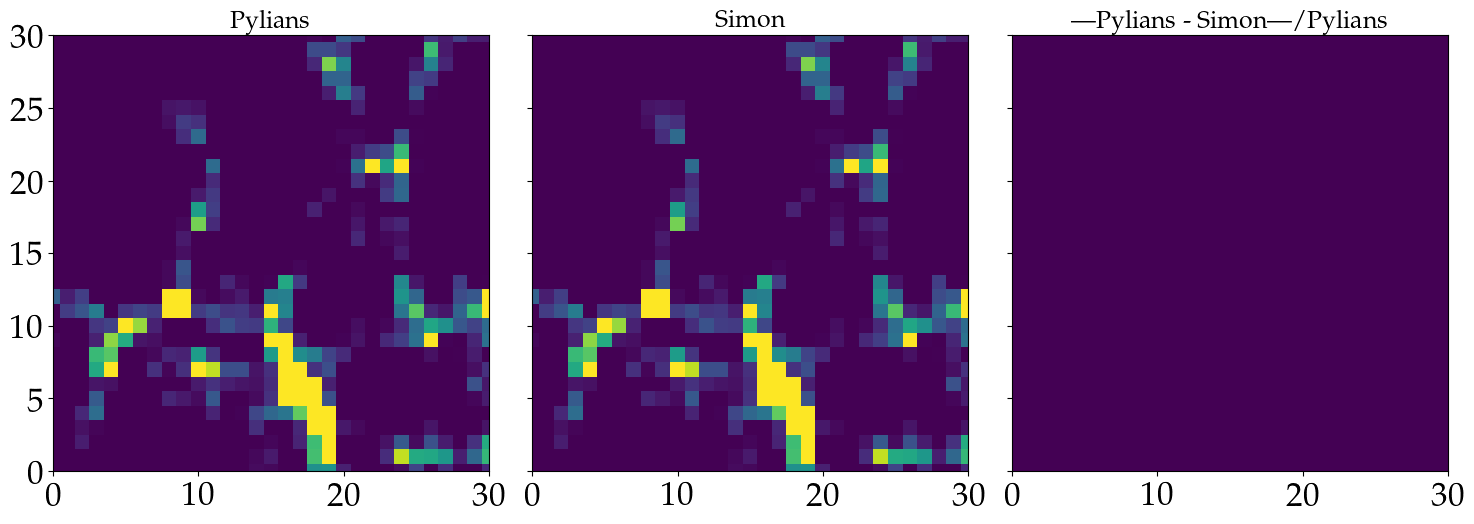

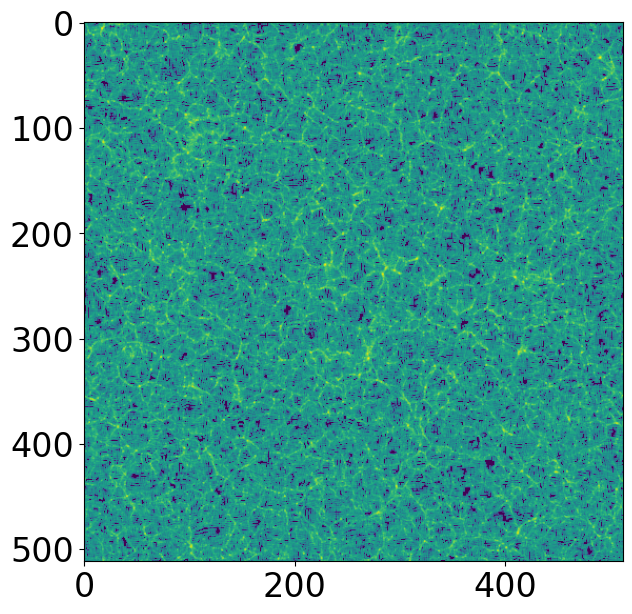

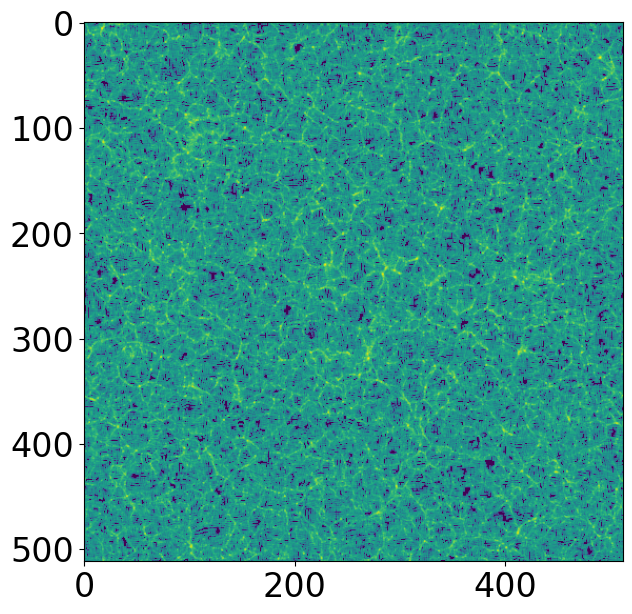

In [12]:
# df_simon.shape
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')


pl.figure()
pl.imshow(np.log(1.0001 + df_pylians[64,:,:]))
pl.figure()
pl.imshow(np.log(1.0001 + df_simon[64,:,:]))




(0.0, 512.0)

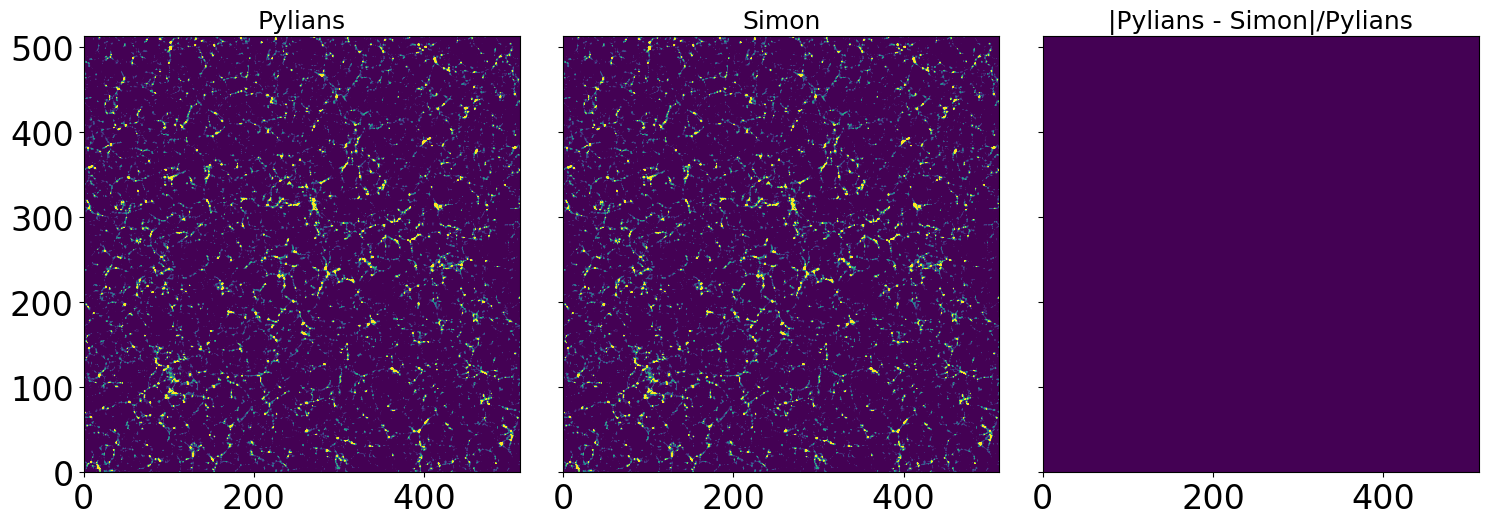

In [14]:
# Nhalos_truth_recomb.shape
# pl.figure()
# pl.imshow(np.log(np.abs(M_halos_truth_recomb[64,:,:,0] - M_halos[64,:,:,0])), origin='lower')
# # pl.imshow(np.log(np.abs(M_halos_truth_recomb[64,:,:,0] - M_halos[64,:,:,0])), origin='lower')
# pl.imshow(M_halos_truth_recomb[64,:,:,0], vmin=13, vmax=16, origin='lower')
# pl.figure()
# pl.imshow(, vmin=13, vmax=16, origin='lower')


fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 0
xmax = 512
axes[0].imshow(df_pylians[64,:,:], vmin=0, vmax=8, origin='lower')
axes[0].set_title('Pylians', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)

axes[1].imshow(df_simon[64,:,:], vmin=0, vmax=8, origin='lower')
axes[1].set_title('Simon', size=18)
axes[1].set_xlim(xmin,xmax)
axes[1].set_ylim(xmin,xmax)

# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow((np.abs(df_pylians[64,:,:] - df_simon[64,:,:])/df_pylians[64,:,:]), vmin=0, vmax=1, origin='lower')
axes[2].set_title('|Pylians - Simon|/Pylians', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)






            

In [52]:
import readfof
import MAS_library as MASL
snap_dir_base='/pscratch/sd/s/spandey/quijote/Halos/fiducial'
snapdir = snap_dir_base + '/' + str(0)  #folder hosting the catalogue
snapnum=4
FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)

# get the properties of the halos
pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h

lgMass_truth = np.log10(mass_truth)

Mmin_Pk, Mmax_Pk = 0, 100.0
indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
print(len(indsel_Pk_truth))
# density field parameters
grid    = grid    #the 3D field will have grid x grid x grid voxels
BoxSize = 1000.0 #Mpc/h ; size of box
MAS     = 'CIC'  #mass-assigment scheme
verbose = True   #print information on progress
pos_halos = pos_h_truth[indsel_Pk_truth,...]

dfhalo_simon = cic(jnp.array(pos_halos[:,0]), jnp.array(pos_halos[:,1]), jnp.array(pos_halos[:,2]), grid, grid, grid, 1e3, 1e3, 1e3)



406660


In [53]:
dfhalo2_ngp = np.float32(np.zeros((grid, grid, grid)))
MASL.NGP(np.float32(pos_halos), dfhalo2_ngp, 1e3)





In [57]:
import jax
from tqdm import tqdm
# @jit
def NGP(pos, grid, BoxSize):
    print(grid)
    number = jnp.zeros((grid, grid, grid))
    particles, coord = pos.shape
    dims = number.shape[0]
    inv_cell_size = dims / BoxSize

    index = jnp.zeros(3, dtype=jnp.int32)
    for i in range(3):
        index = index.at[i].set(0)

    for i in tqdm(range(particles)):
        for axis in range(coord):
            index = index.at[axis].set(jnp.int32(pos[i, axis] * inv_cell_size + 0.5))
            index = index.at[axis].set((index[axis] + dims) % dims)
        number = number.at[index[0], index[1], index[2]].add(1.0)
    return number
        
        
        
        

In [63]:
index = jnp.zeros((3,3,3))
index.at[0].set(1)
print(index)


[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [58]:
# from jax import jit, lax
# def NGP2(pos, grid, BoxSize):
#     number = jnp.zeros((grid, grid, grid))
#     particles, coord = pos.shape
#     dims = number.shape[0]
#     inv_cell_size = dims / BoxSize

#     index = jnp.zeros(3, dtype=jnp.int32)
#     for i in range(3):
#         index = lax.index_update(index, i, 0)

#     for i in range(particles):
#         for axis in range(coord):
#             index = lax.index_update(index, axis, jnp.int32(pos[i, axis] * inv_cell_size + 0.5))
#             index = lax.index_update(index, axis, (index[axis] + dims) % dims)
#         number = lax.index_add(number, (index[0], index[1], index[2]), 1.0)
#     return number


In [59]:
dfhalo3_ngp = NGP(jnp.float32(pos_halos), int(128), float(1e3))



128


  0%|          | 835/406660 [00:12<1:39:56, 67.67it/s]


KeyboardInterrupt: 

(0.0, 30.0)

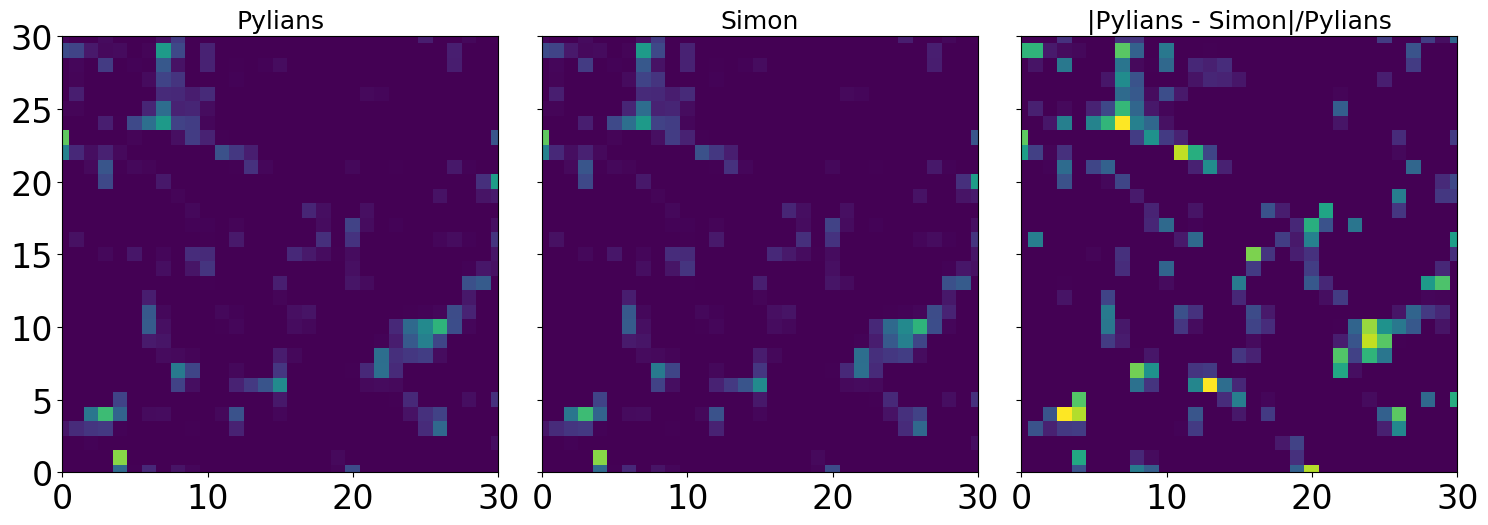

In [42]:
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 0
xmax = 30
axes[0].imshow(df_pylians[64,:,:], vmin=0, vmax=8, origin='lower')
axes[0].set_title('Pylians', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)

axes[1].imshow(df_simon[64,:,:], vmin=0, vmax=8, origin='lower')
axes[1].set_title('Simon', size=18)
axes[1].set_xlim(xmin,xmax)
axes[1].set_ylim(xmin,xmax)

# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow(dfhalo_simon[64,:,:], vmin=0, vmax=8, origin='lower')
axes[2].set_title('|Pylians - Simon|/Pylians', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)






            



In [43]:
import numpy as np
import h5py as h5
df = h5.File('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/run_models/truth_halo_ns128.h5', 'r')
pos_h_truth = np.vstack((df['x_h'][()],df['y_h'][()],df['z_h'][()])).T
lgMass_truth = df['lgMass_mock'][()]
# dfhalo2_simon = cic(jnp.array(pos_h_truth[:,0]), jnp.array(pos_h_truth[:,1]), jnp.array(pos_h_truth[:,2]), grid, grid, grid, 1e3, 1e3, 1e3)




(30.0, 40.0)

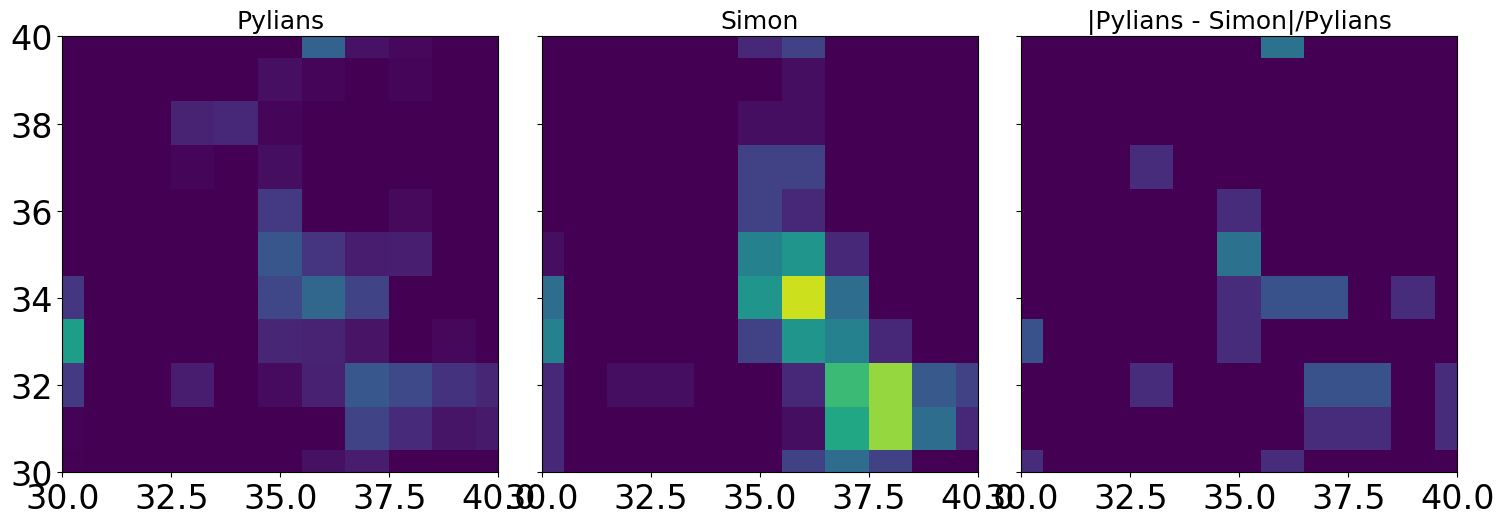

In [44]:
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 30
xmax = 40
axes[0].imshow(df_pylians[64,:,:], vmin=0, vmax=8, origin='lower')
axes[0].set_title('Pylians', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)

axes[1].imshow(dfhalo2_simon[64,:,:], vmin=0, vmax=8, origin='lower')
axes[1].set_title('Simon', size=18)
axes[1].set_xlim(xmin,xmax)
axes[1].set_ylim(xmin,xmax)

# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow(dfhalo2_ngp[64,:,:], vmin=0, vmax=8, origin='lower')
axes[2].set_title('|Pylians - Simon|/Pylians', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)






            



In [14]:
%load_ext Cython
import numpy as np


The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [15]:
# %%cython
# def sum_list(list arr):
#     cdef int total = 0
#     cdef int i
#     for i in range(len(arr)):
#         total += arr[i]
#     return total



In [16]:
# print(sum_list([1, 2, 3, 4, 5]))



In [53]:
import readfof
import MAS_library as MASL
snap_dir_base='/pscratch/sd/s/spandey/quijote/Halos/fiducial'
snapdir = snap_dir_base + '/' + str(0)  #folder hosting the catalogue
snapnum=4
FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)

# get the properties of the halos
pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h

lgMass_truth = np.log10(mass_truth)

Mmin_Pk, Mmax_Pk = 0, 100.0
indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
print(len(indsel_Pk_truth))
# density field parameters
grid    = 128    #the 3D field will have grid x grid x grid voxels
BoxSize = 1000.0 #Mpc/h ; size of box
# MAS     = 'CIC'  #mass-assigment scheme
# verbose = True   #print information on progress
pos_halos = pos_h_truth[indsel_Pk_truth,...]

# dfhalo_simon = cic(jnp.array(pos_halos[:,0]), jnp.array(pos_halos[:,1]), jnp.array(pos_halos[:,2]), grid, grid, grid, 1e3, 1e3, 1e3)


dfhalo2_ngp = np.float32(np.zeros((grid, grid, grid)))
MASL.NGP(np.float32(pos_halos), dfhalo2_ngp, BoxSize)






406660


In [54]:
# %%cython

# cimport numpy as np
# cpdef void NGP(np.float32_t[:,:] pos, np.float32_t[:,:,:] number, float BoxSize):

#     cdef int axis,dims,coord
#     cdef long i,particles
#     cdef float inv_cell_size
#     cdef int index[3]

#     # find number of particles, the inverse of the cell size and dims
#     particles = pos.shape[0];  coord = pos.shape[1];  dims = number.shape[0]
#     inv_cell_size = dims/BoxSize

#     # when computing things in 2D, use the index[2]=0 plane
#     for i in range(3):  index[i] = 0

#     # do a loop over all particles
#     for i in range(particles):
#         for axis in range(coord):
#             index[axis] = <int>(pos[i,axis]*inv_cell_size + 0.5)
#             index[axis] = (index[axis]+dims)%dims
#         number[index[0],index[1],index[2]] += 1.0
        
        
        

In [55]:
%%cython

cimport numpy as np
cpdef void NGP_mass(np.float32_t[:,:] pos, np.float32_t[:] logM, np.float32_t[:,:,:,:] gridM, float BoxSize):

    cdef int axis,dims,coord,nMmax,jM
    cdef long i,particles
    cdef float inv_cell_size
    cdef int index[3]

    # find number of particles, the inverse of the cell size and dims
    particles = pos.shape[0];  coord = pos.shape[1];  dims = gridM.shape[0]; nMmax = gridM.shape[3]
    inv_cell_size = dims/BoxSize

    # when computing things in 2D, use the index[2]=0 plane
    for i in range(3):  index[i] = 0

    # do a loop over all particles
    for i in range(particles):
        for axis in range(coord):
            index[axis] = <int>(pos[i,axis]*inv_cell_size + 0.5)
            index[axis] = (index[axis]+dims)%dims
        for jM in range(nMmax):
            if gridM[index[0],index[1],index[2], jM] == 0:
                gridM[index[0],index[1],index[2], jM] = logM[i]
                break
            else:
                pass
        
        
        

In [56]:
nMmax = 10
dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMmax)))
NGP_mass(np.float32(pos_halos), np.float32(lgMass_truth), dfhalo_ngp_wmass, BoxSize)




In [66]:
dfhalo_ngp_wmass_sorted = np.flip(np.sort(dfhalo_ngp_wmass, axis=-1), axis=-1)




In [60]:
# %pip install Pylians
import sys, os
root         = '/pscratch/sd/s/spandey/quijote/Snapshot_fid'
root_out     = '/pscratch/sd/s/spandey/quijote/Snapshot_fid/Snapshot_fid_density'
ptypes       = [1]
snapnum      = 0
grid         = 128
# numbers = np.arange(0,17)
# for i in numbers:
i = 0
print(i)
# for snapnum in [0,1,2,3,4]:
snapnum = 4
print(snapnum)
# find the redshift
z = {4:0, 3:0.5, 2:1, 1:2, 0:3}[snapnum]

# create output folder if it does not exists
folder_out = '%s/%d'%(root_out,i)
if not(os.path.exists(folder_out)):
    os.system('mkdir %s'%folder_out)

# find name of output file
fout = '%s/df_m_%d_z=%s.npy'%(folder_out,grid,z)
# if os.path.exists(fout):  continue

# compute the density field and save it to file
snapshot = '%s/%d/snapdir_%03d/snap_%03d'%(root,i,snapnum,snapnum)
df = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
                               do_RSD=False, axis=0, verbose=True)
df_pylians = df/np.mean(df, dtype=np.float64)-1.0

# compute_df(snapshot, ptypes, grid, fout)




0
4

Computing density field of particles [1]
1.34217728e+08 should be equal to
1.34217728e+08
Time taken = 2.20 seconds


In [63]:
import matplotlib

import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')
%matplotlib inline


Text(0.5, 1.0, '10.5$< \\delta_m < $50.4')

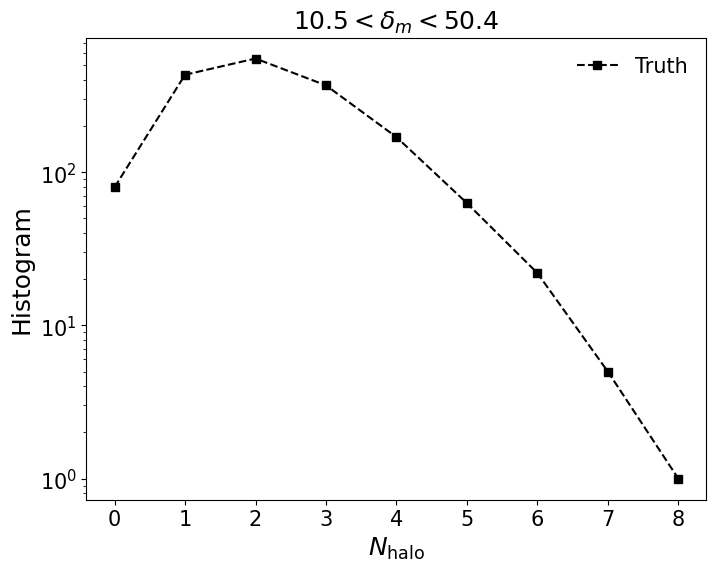

In [65]:
delta_min_p, delta_max_p = 10.5, 50.4
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
pl.figure(figsize=(8,6))
bin_cents = np.array([0,1,2,3,4,5,6,7,8])
bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
bin_edges = np.insert(bin_edges,0, -0.5)
bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)
hist_truth, _ = np.histogram(dfhalo2_ngp[indsel_dp].flatten(), bins=bin_edges)
# _ = pl.hist(df_Nh_truth[indsel_dp].flatten(), histtype='step', bins=[0,1,2,3,4,5,6,7,8], label='Truth')
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Truth')
# hist_samp, _ = np.histogram(Nhalos_truth_recomb[indsel_dp].flatten(), bins=bin_edges)
# _ = pl.hist(, bins=[0,1,2,3,4,5,6,7,8], label='Sampled')
# pl.plot(bin_cents, hist_samp, marker='o', color='b', ls='-', label='Sampled')
pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$N_{\rm halo}$', size=18)
pl.ylabel('Histogram', size=18)
pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




(0.0, 100.0)

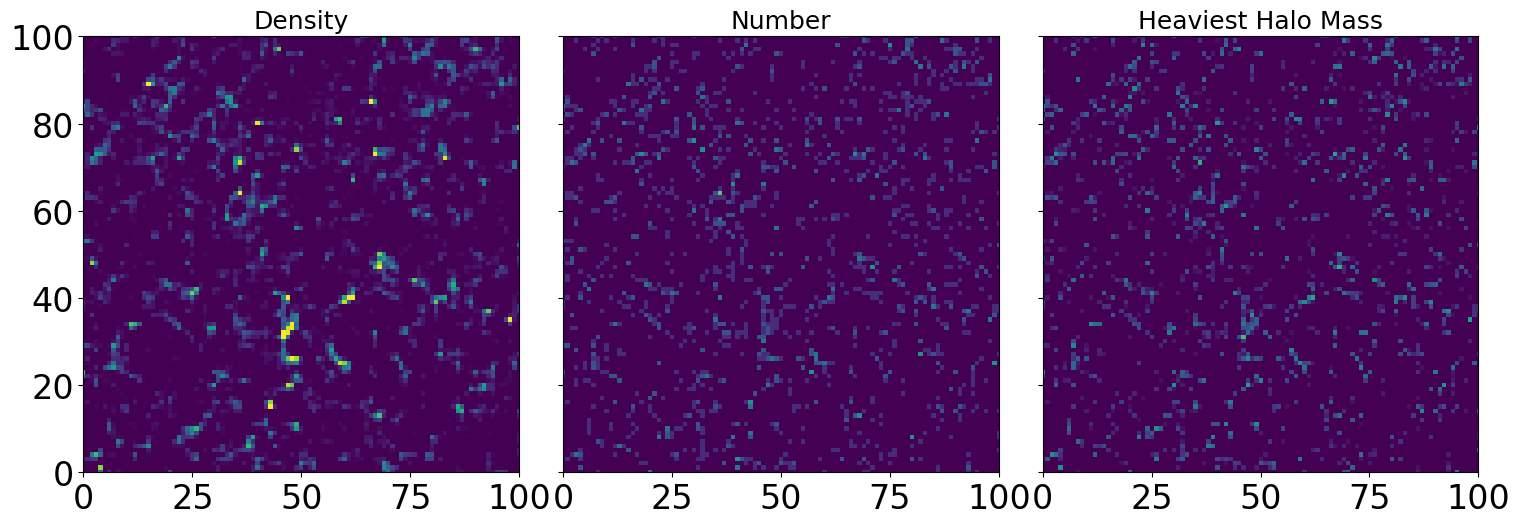

In [76]:
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 0
xmax = 100
axes[0].imshow(df_pylians[64,:,:], vmin=0, vmax=8, origin='lower')
axes[0].set_title('Density', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)

axes[1].imshow(dfhalo2_ngp[64,:,:], vmin=0, vmax=8, origin='lower')
axes[1].set_title('Number', size=18)
axes[1].set_xlim(xmin,xmax)
axes[1].set_ylim(xmin,xmax)

# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow(dfhalo_ngp_wmass_sorted[64,:,:, 0], vmin=13, vmax=16, origin='lower')
axes[2].set_title('Heaviest Halo Mass', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)





            


Text(0, 0.5, 'Histogram Density')

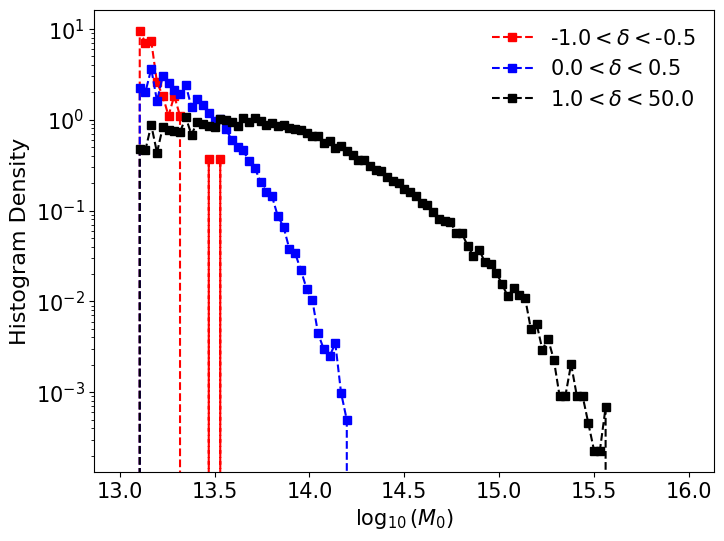

In [91]:
bin_edges = np.linspace(13, 16, 100)
bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])


pl.figure(figsize=(8,6))
delta_min_p, delta_max_p = -1.0, -0.5
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='r', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p))

delta_min_p, delta_max_p = 0.0, 0.5
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='b', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p))


delta_min_p, delta_max_p = 1.0, 50.0
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label=str(delta_min_p) + r'$ < \delta <$' + str(delta_max_p))


pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$\log_{10}(M_{0})$', size=15)
pl.ylabel('Histogram Density', size=16)
# pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




Text(0.5, 1.0, '1.0$< \\delta_m < $50.0')

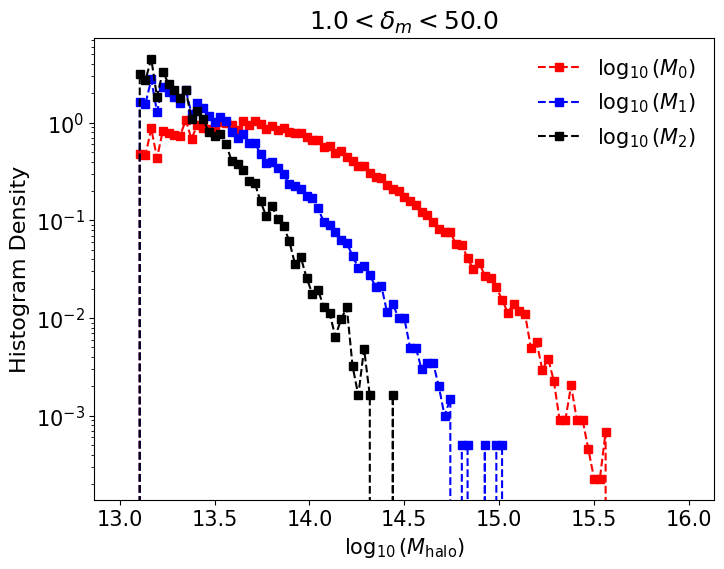

In [92]:
bin_edges = np.linspace(13, 16, 100)
bin_cents = 0.5*(bin_edges[1:] + bin_edges[:-1])


pl.figure(figsize=(8,6))
delta_min_p, delta_max_p = 1.0, 50.0
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='r', ls='--', label=r'$\log_{10}(M_0)$')

hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,1][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='b', ls='--', label=r'$\log_{10}(M_1)$')

hist_truth, _ = np.histogram(dfhalo_ngp_wmass_sorted[...,2][indsel_dp].flatten(), bins=bin_edges, density=True)
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label=r'$\log_{10}(M_2)$')


pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel('Histogram Density', size=16)
pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)




Text(0, 0.5, '$\\log_{10}(M_{0})$')

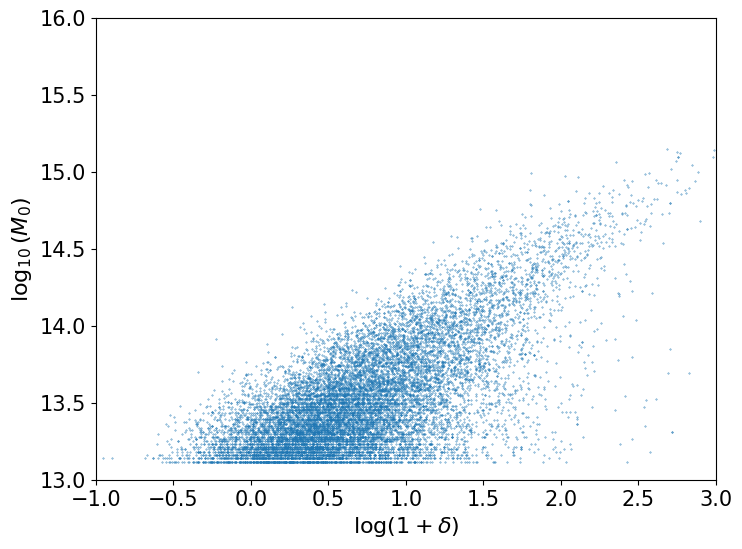

In [110]:
pl.figure(figsize=(8,6))
delta_min_p, delta_max_p = -1.0, 50.0
indsel_dp = np.where((df_pylians > delta_min_p) & (df_pylians < delta_max_p))
density_list = df_pylians[indsel_dp].flatten()
logM_list = dfhalo_ngp_wmass_sorted[...,0][indsel_dp].flatten()
indsel_rand = np.random.randint(0, len(density_list), np.amin(np.array([len(density_list), 100000])))
pl.scatter(np.log(1+density_list[indsel_rand]),logM_list[indsel_rand], s=0.1)
# pl.xscale('log')
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.ylim(13, 16)
pl.xlim(-1,3)
pl.xlabel(r'$\log(1 + \delta)$', size=16)
pl.ylabel(r'$\log_{10}(M_{0})$', size=16)

# pl.xlim(delta_min_p-0.1, delta_max_p)




In [116]:
Nhalos = dfhalo2_ngp
M_halos = dfhalo_ngp_wmass_sorted
nMax_h = dfhalo_ngp_wmass_sorted.shape[-1]


In [117]:
# now split it into nbatches each side
n_batch = 8
subvol_size = grid // n_batch
nsubvol = n_batch**3
save_subvol_Nhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
save_subvol_Mhalo = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size, nMax_h))
save_subvol_density_unpad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))

jc = 0
from tqdm import tqdm
for jx in tqdm(range(n_batch)):
    for jy in range(n_batch):
        for jz in range(n_batch):
            # get the sub-cube
            save_subvol_Nhalo[jc] = Nhalos[jx * subvol_size:(jx + 1) * subvol_size,
                                           jy * subvol_size:(jy + 1) * subvol_size,
                                           jz * subvol_size:(jz + 1) * subvol_size]
            save_subvol_Mhalo[jc] = M_halos[jx * subvol_size:(jx + 1) * subvol_size,
                                            jy * subvol_size:(jy + 1) * subvol_size,
                                            jz * subvol_size:(jz + 1) * subvol_size]
            save_subvol_density_unpad[jc] = df_pylians[jx * subvol_size:(jx + 1) * subvol_size,
                                           jy * subvol_size:(jy + 1) * subvol_size,
                                           jz * subvol_size:(jz + 1) * subvol_size]
            jc += 1

            
            

100%|██████████| 8/8 [00:00<00:00, 213.43it/s]


In [121]:
# grid

n_filter = 3
n_cnn = 7
n_dim_red = (n_filter - 1) // 2

n_pad = n_dim_red * n_cnn
df_pad = np.pad(df_pylians, n_pad, 'wrap')

# we want to split the df_pad into n_batch^3 sub-cubes, but centered on the original df simulation box
xstart, ystart, zstart = n_pad, n_pad, n_pad
subvol_size = grid // n_batch + 2 * n_pad
nsubvol = n_batch**3
save_subvol_density_pad = np.zeros((nsubvol, subvol_size, subvol_size, subvol_size))
jc = 0
from tqdm import tqdm
for jx in tqdm(range(n_batch)):
    for jy in range(n_batch):
        for jz in range(n_batch):
            # get the sub-cube
            df_sub = df_pad[xstart + jx * grid // n_batch - n_pad:xstart + (jx + 1) * grid // n_batch + n_pad,
                            ystart + jy * grid // n_batch - n_pad:ystart + (jy + 1) * grid // n_batch + n_pad,
                            zstart + jz * grid // n_batch - n_pad:zstart + (jz + 1) * grid // n_batch + n_pad]
            # save the sub-cube
            save_subvol_density_pad[jc, ...] = df_sub
            jc += 1


100%|██████████| 8/8 [00:00<00:00, 500.37it/s]


In [124]:
save_subvol_density_pad.shape, save_subvol_density_unpad.shape, 2 * n_pad




((512, 30, 30, 30), (512, 16, 16, 16), 14)

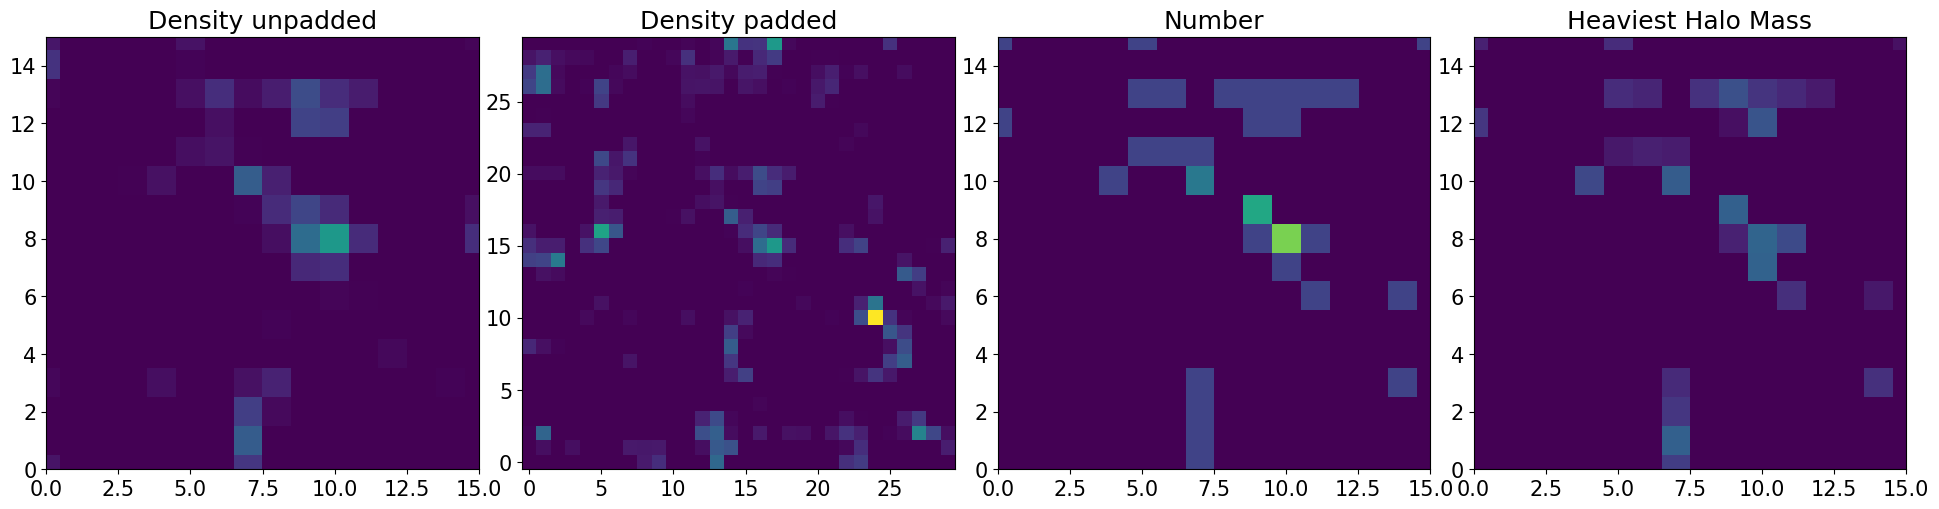

In [148]:
fig, axes = pl.subplots(nrows=1, ncols=4, figsize=(24, 8))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 0
xmax = 15
axes[0].imshow(save_subvol_density_unpad[0,8,...], vmin=0, vmax=8, origin='lower')
axes[0].set_title('Density unpadded', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[0].tick_params(axis='both', which='minor', labelsize=15)


axes[1].imshow(save_subvol_density_pad[0, n_pad + 8,...], vmin=0, vmax=8, origin='lower')
axes[1].set_title('Density padded', size=18)
# axes[1].set_xlim(xmin+n_pad,xmax+n_pad)
# axes[1].set_ylim(xmin+n_pad,xmax+n_pad)
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[1].tick_params(axis='both', which='minor', labelsize=15)


# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow(save_subvol_Nhalo[0,8,...], vmin=0, vmax=5, origin='lower')
axes[2].set_title('Number', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)
axes[2].tick_params(axis='both', which='major', labelsize=15)
axes[2].tick_params(axis='both', which='minor', labelsize=15)


axes[3].imshow(save_subvol_Mhalo[..., 0][0,8,...], vmin=13, vmax=16, origin='lower')
axes[3].set_title('Heaviest Halo Mass', size=18)
axes[3].set_xlim(xmin,xmax)
axes[3].set_ylim(xmin,xmax)
axes[3].tick_params(axis='both', which='major', labelsize=15)
axes[3].tick_params(axis='both', which='minor', labelsize=15)





            





In [135]:
# save_subvol_Mhalo.shape

# save_subvol_density_pad[0, n_pad + 8,...].shape
xmin+n_pad,xmax+n_pad


(7, 23)